In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1818188%2F2965537%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240618%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240618T102143Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da5a8d16f09b93f98755aef703b372b476789d6f03076feb908ac302883ad13bf4b4b8b66b2ae063945715d7e35f0bc011eef9897064ebc639aeb7d673b6c17fdcfdde36f9de37bf52b8468b8f8dddecc6035556306a011d8e00f36a1f37de307b139622a5e7ee05933f3a566d6e4b2f9ccedfd37f607e77e677935713453d4a23fbb3aded9c006483ca3adf115bce1120b7bd5a7ebd6c93b4b56bc7e9204c2fc1cd41a12ba7e90b171c9dbf2c8403290485fae316f231eef8e78f69d18e27045d1d15c317c441ee74baa7d27c614ffa3900b0bb6d469816c258ea15f9be6b3b803fe91e1734f465bea39e674b64722b2c04faf4543ea3c8440338631cd50c190'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 22564 bytes downloaded
Downloaded and uncompressed: titanic-dataset
Data source import complete.


# IMPORT THE LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# READ THE DATASET

In [3]:
data=pd.read_csv("/kaggle/input/titanic-dataset/Titanic-Dataset.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# DATA ANALYSIS

In [4]:
data.shape

(891, 12)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
 1   Pclass    891 non-null    int64
 2   Sex       891 non-null    int64
 3   Age       891 non-null    int64
 4   SibSp     891 non-null    int64
 5   Parch     891 non-null    int64
 6   Fare      891 non-null    int64
 7   Embarked  891 non-null    int64
dtypes: int64(8)
memory usage: 55.8 KB


"AGE","CABIN" AND "EMBARKED" HAVE MISSING VALUES

In [6]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
data.describe(include="object")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [8]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
data.duplicated().unique()

array([False])

In [10]:
data["Pclass"].unique()

array([3, 1, 2])

"Pclass" REPRESENTS TICKET CLASS OF THE PASSENGERS.

In [11]:
data["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

"Embarked" REPRESENTS ABBREVIATIONS FOR STATIONS.

<ipython-input-12-52dd71ccd852>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar1=sns.barplot(x=data1["Survived"],y=data1["Count"],palette=['r','g'])


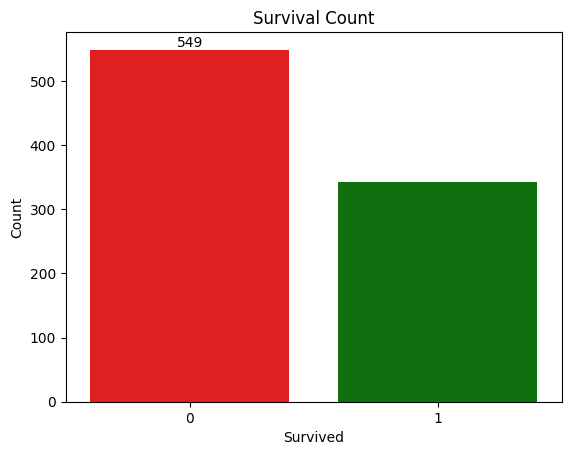

In [12]:
data1=data["Survived"].value_counts().reset_index()
data1.columns=["Survived","Count"]
bar1=sns.barplot(x=data1["Survived"],y=data1["Count"],palette=['r','g'])
bar1.bar_label(bar1.containers[0])
plt.title("Survival Count")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.show()

COUNT OF SURVIVORS WAS LESS THAN THE PEOPLE WHO LOST THEIR LIVES

<ipython-input-13-544c6f72f92a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar2=sns.barplot(x=data2["Pclass"],y=data2["Count"],palette=['r','g','y'])


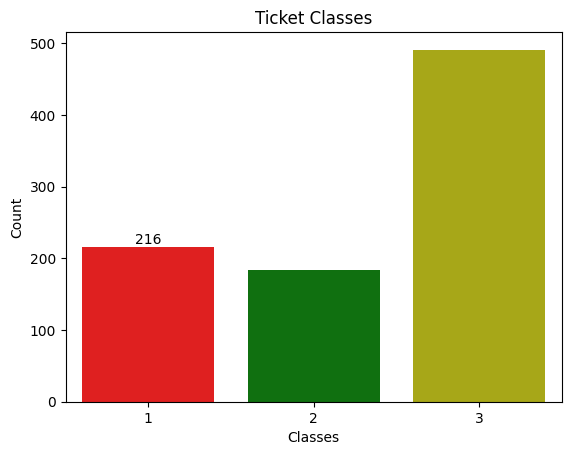

In [13]:










data2=data["Pclass"].value_counts().reset_index()
data2.columns=["Pclass","Count"]
bar2=sns.barplot(x=data2["Pclass"],y=data2["Count"],palette=['r','g','y'])
bar2.bar_label(bar2.containers[0])
plt.title("Ticket Classes")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

PEOPLE TRAVELLED MORE IN 3RD CLASS.

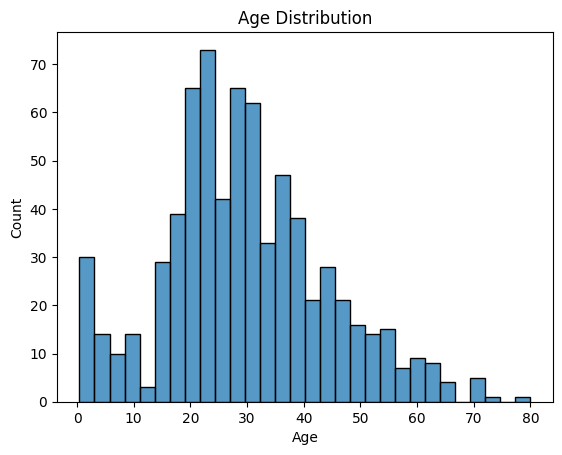

In [14]:

sns.histplot(x=data["Age"],bins=30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()

THIS SHOWS MAXIMUM NUMBER OF PEOPLE TRAVELLED BETWEEN AGE 20-40 YEARS

<ipython-input-15-6c61c904c5c4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar3=sns.barplot(x=data3["Sex"],y=data3["Count"],palette=['r','g','y'])
<ipython-input-15-6c61c904c5c4>:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  bar3=sns.barplot(x=data3["Sex"],y=data3["Count"],palette=['r','g','y'])


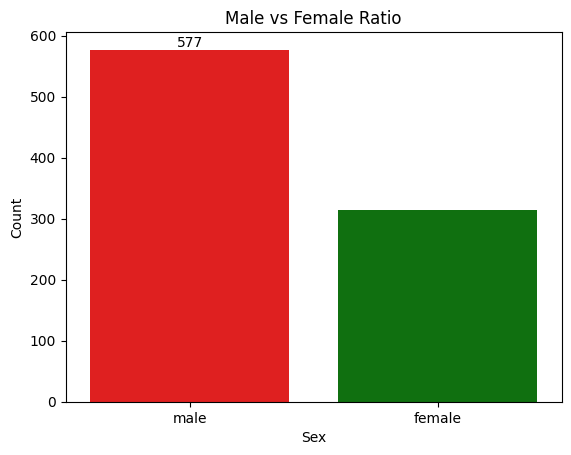

In [15]:








data3=data["Sex"].value_counts().reset_index()
data3.columns=["Sex","Count"]
bar3=sns.barplot(x=data3["Sex"],y=data3["Count"],palette=['r','g','y'])
bar3.bar_label(bar3.containers[0])
plt.title("Male vs Female Ratio")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

MALES TRAVELLED MORE THAN FEMALES

<ipython-input-16-0555bfee5f37>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar4=sns.barplot(x=data4["Embarked"],y=data4["Count"],palette=['k','b','m'])


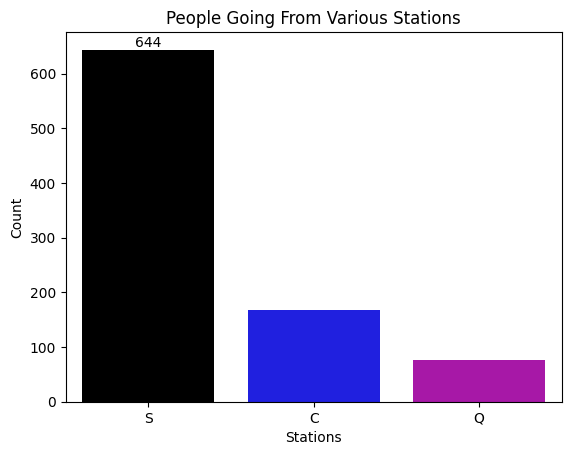

In [16]:
data4=data["Embarked"].value_counts().reset_index()
data4.columns=["Embarked","Count"]
bar4=sns.barplot(x=data4["Embarked"],y=data4["Count"],palette=['k','b','m'])
bar4.bar_label(bar4.containers[0])
plt.title("People Going From Various Stations")
plt.xlabel("Stations")
plt.ylabel("Count")
plt.show()

MAXIMUM NUMBER OF PEOPLE WERE TRAVELLING FROM STATION "S".

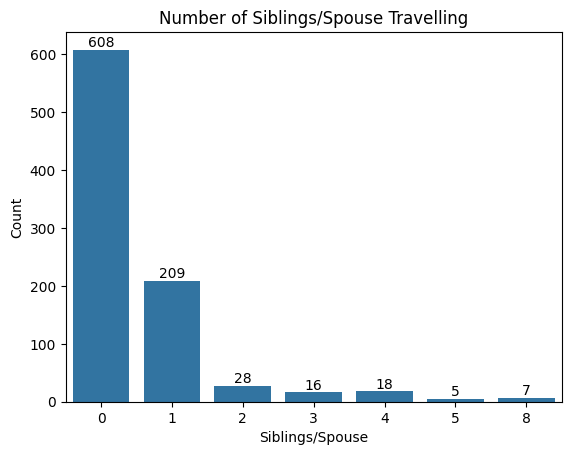

In [17]:
data5=data["SibSp"].value_counts().reset_index()
data5.columns=["SibSp","Count"]
bar5=sns.barplot(x=data5["SibSp"],y=data5["Count"])
bar5.bar_label(bar5.containers[0])
plt.title("Number of Siblings/Spouse Travelling")
plt.xlabel("Siblings/Spouse")
plt.ylabel("Count")
plt.show()

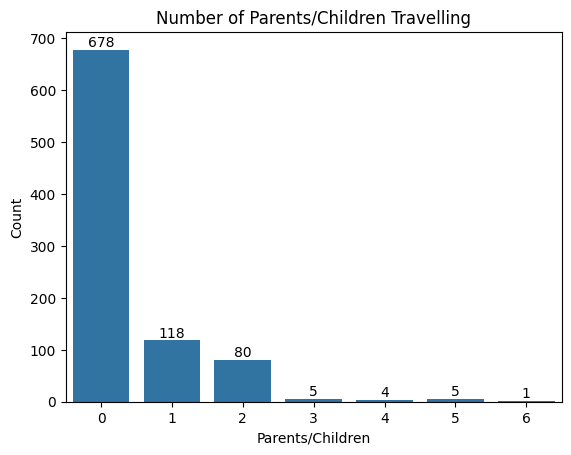

In [18]:
data6=data["Parch"].value_counts().reset_index()
data6.columns=["Parch","Count"]
bar6=sns.barplot(x=data6["Parch"],y=data6["Count"])
bar6.bar_label(bar6.containers[0])
plt.title("Number of Parents/Children Travelling")
plt.xlabel("Parents/Children")
plt.ylabel("Count")
plt.show()

BOTH SPOUSES/SIBLINGS AND PARENT/CHILDREN GRAPH SHOWS THAT MAXIMUM PEOPLE TRAVELLED ALONE

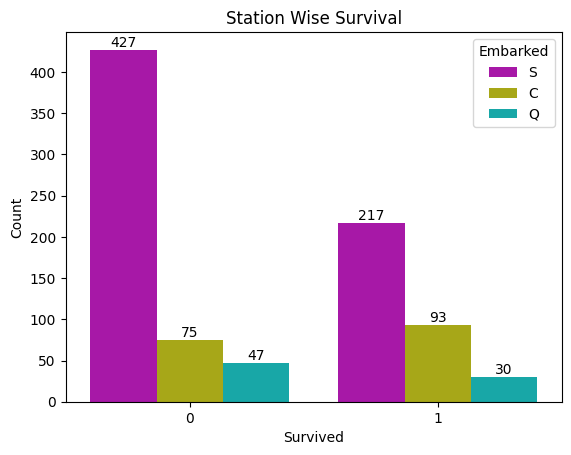

In [19]:
data7=data[["Survived","Embarked"]].value_counts().reset_index()
data7.columns=["Survived","Embarked","Count"]
bar7=sns.barplot(x=data7["Survived"],y=data7["Count"],hue=data7["Embarked"],palette=['m','y','c'])
bar7.bar_label(bar7.containers[0])
bar7.bar_label(bar7.containers[1])
bar7.bar_label(bar7.containers[2])
plt.title("Station Wise Survival")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.show()

MAXIMUM PEOPLE WHO DIED WERE FROM STATION "S"

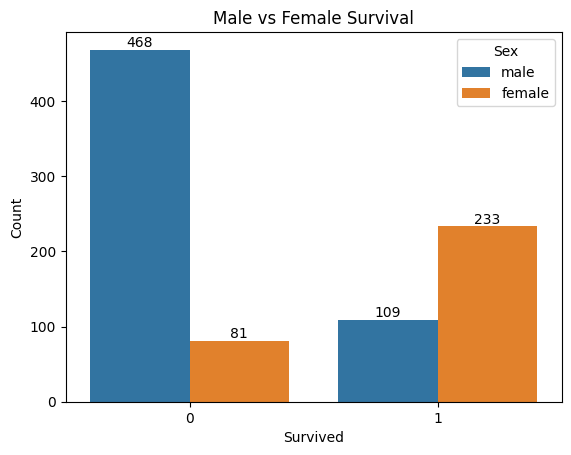

In [20]:
data8=data[["Survived","Sex"]].value_counts().reset_index()
data8.columns=["Survived","Sex","Count"]
bar8=sns.barplot(x=data8["Survived"],y=data8["Count"],hue=data8["Sex"])
bar8.bar_label(bar8.containers[0])
bar8.bar_label(bar8.containers[1])
plt.title("Male vs Female Survival")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.show()

FEMALES SURVIVED MORE THAN MALES

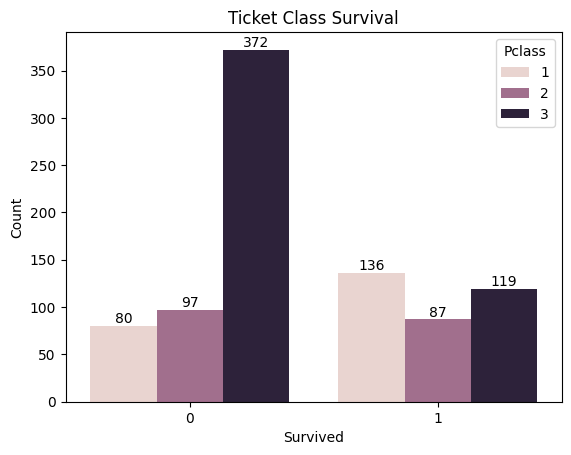

In [21]:
data9=data[["Survived","Pclass"]].value_counts().reset_index()
data9.columns=["Survived","Pclass","Count"]
bar9=sns.barplot(x=data9["Survived"],y=data9["Count"],hue=data9["Pclass"])
bar9.bar_label(bar9.containers[0])
bar9.bar_label(bar9.containers[1])
bar9.bar_label(bar9.containers[2])
plt.title("Ticket Class Survival")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.show()

PEOPLE WHO TRAVELLED IN 3RD CLASS DIED MORE

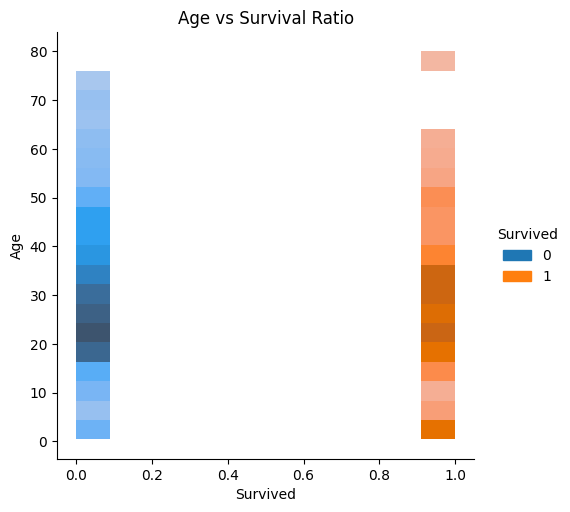

In [22]:
sns.displot(x=data["Survived"],y=data["Age"],hue=data["Survived"])
plt.title("Age vs Survival Ratio")
plt.show()

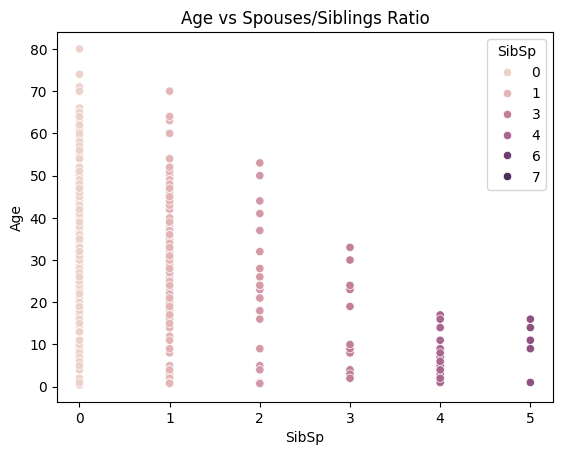

In [23]:
sns.scatterplot(x=data["SibSp"],y=data["Age"],hue=data["SibSp"])
plt.title("Age vs Spouses/Siblings Ratio")
plt.show()

PEOPLE BETWEEN 0-30 YEARS TRAVELLED WITH >=4 PEOPLE.

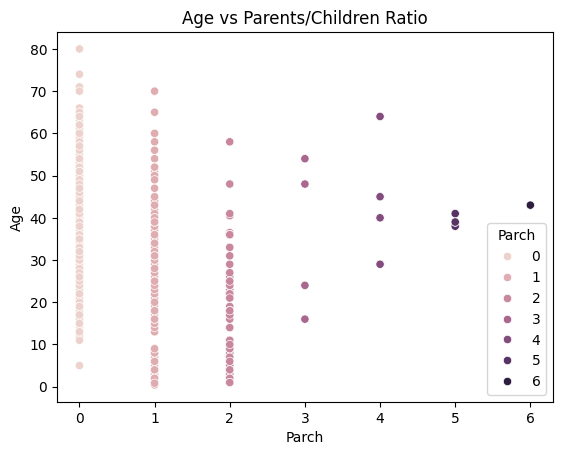

In [24]:
sns.scatterplot(x=data["Parch"],y=data["Age"],hue=data["Parch"])
plt.title("Age vs Parents/Children Ratio")
plt.show()

AS YOU CAN SEE PEOPLE AGED BETWEEN 30-70 YEARS TRAVELLED WITH THEIR CHILDEN.

# DATA PREPROCESSING

#### ENCODING "Sex" AND "Embarked" COLUMN

In [25]:
data["Sex"]=data["Sex"].map({"male":1,"female":0})
data["Embarked"]=data["Embarked"].map({"S":0,"C":1,"Q":2})


In [26]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0.0


#### ENCODING "Name", "Ticket" AND "Cabin"	COLUMNS

In [27]:
le=LabelEncoder()
data["Name"]=le.fit_transform(data["Name"])
data["Ticket"]=le.fit_transform(data["Ticket"])

In [28]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,108,1,22.0,1,0,523,7.2500,NaN,0.0
1,2,1,1,190,0,38.0,1,0,596,71.2833,C85,1.0
2,3,1,3,353,0,26.0,0,0,669,7.9250,NaN,0.0
3,4,1,1,272,0,35.0,1,0,49,53.1000,C123,0.0
4,5,0,3,15,1,35.0,0,0,472,8.0500,NaN,0.0


#### HANDLING MISSING VALUES

In [29]:
data['Age'].fillna(data["Age"].median(), inplace=True)


In [30]:
data['Age'].isnull().sum()

0

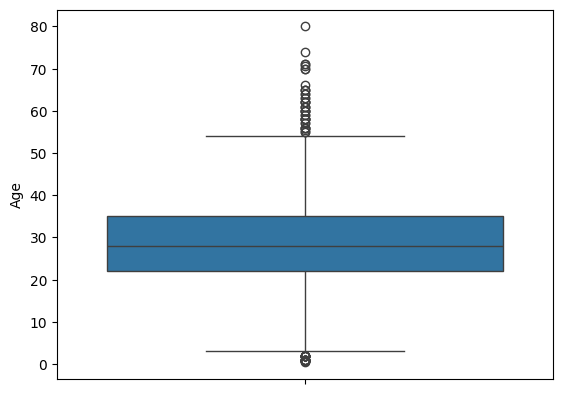

In [31]:
sns.boxplot(y=data["Age"])
plt.show()

In [32]:



data["Embarked"].fillna(data["Embarked"].mode()[0], inplace=True)

In [33]:

data["Embarked"].isnull().sum()

0

#### CHANGING DATATYPE TO INTEGER

In [34]:
data["Age"]=data["Age"].astype(int)
data["Embarked"]=data["Embarked"].astype(int)
data["Fare"]=data["Fare"].astype(int)

In [35]:


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Survived     891 non-null    int64 
 2   Pclass       891 non-null    int64 
 3   Name         891 non-null    int64 
 4   Sex          891 non-null    int64 
 5   Age          891 non-null    int64 
 6   SibSp        891 non-null    int64 
 7   Parch        891 non-null    int64 
 8   Ticket       891 non-null    int64 
 9   Fare         891 non-null    int64 
 10  Cabin        204 non-null    object
 11  Embarked     891 non-null    int64 
dtypes: int64(11), object(1)
memory usage: 83.7+ KB


# FEATURE ENGINEERING

#### DROPPING 'Cabin' AS IT HAS TWO MANY NULL VALUES

In [36]:
data.drop('Cabin',axis=1,inplace=True)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,108,1,22,1,0,523,7,0
1,2,1,1,190,0,38,1,0,596,71,1
2,3,1,3,353,0,26,0,0,669,7,0
3,4,1,1,272,0,35,1,0,49,53,0
4,5,0,3,15,1,35,0,0,472,8,0


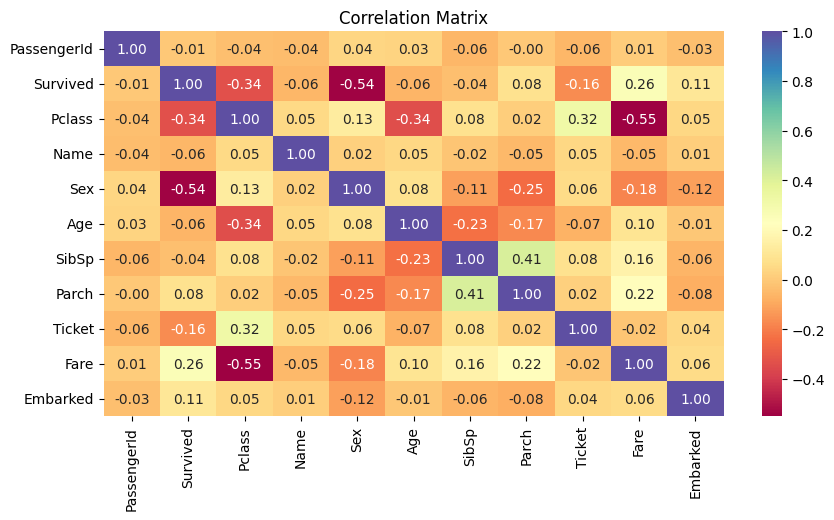

In [37]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(),fmt=".2f",annot=True,cmap="Spectral")
plt.title("Correlation Matrix")
plt.show()

#### DROPPING "PassengerId", "Name" AND "Ticket" AS THEY ARE JUST UNIQUE IDENTIFIERS

In [38]:
data.drop(["PassengerId","Name","Ticket"],axis=1,inplace=True)

In [39]:
features=data.drop("Survived",axis=1)
target=data["Survived"]

In [40]:
features.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22,1,0,7,0
1,1,0,38,1,0,71,1
2,3,0,26,0,0,7,0
3,1,0,35,1,0,53,0
4,3,1,35,0,0,8,0


In [41]:
target.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

#### CHI SQUARE TEST

In [42]:
chi_test=chi2(features,target)


###### F-VALUE

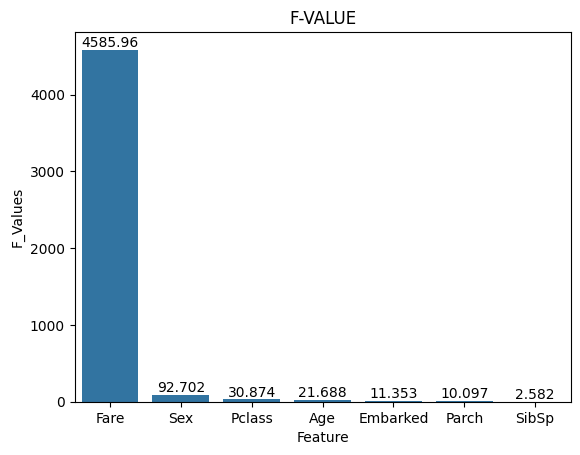

In [43]:
value1=chi_test[0]
f_value=pd.Series(value1)
f_value.index=features.columns
df1=pd.DataFrame({"Feature":f_value.index,"F_Values":f_value})
df1.sort_values(ascending=False,by="F_Values",inplace=True)
df1["F_Values"]=df1["F_Values"].round(3)
bar10=sns.barplot(x="Feature",y="F_Values",data=df1)
bar10.bar_label(bar10.containers[0])
plt.title("F-VALUE")
plt.show()

###### P-VALUE

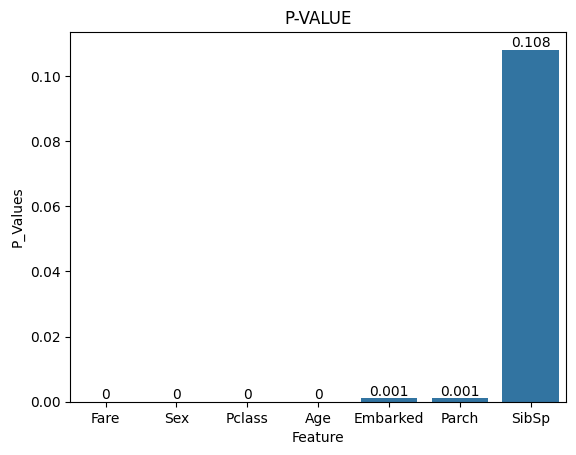

In [44]:
value2=chi_test[1]
p_value=pd.Series(value2)
p_value.index=features.columns
df2=pd.DataFrame({"Feature":p_value.index,"P_Values":p_value})
df2.sort_values(ascending=True,by="P_Values",inplace=True)
df2["P_Values"]=df2["P_Values"].round(3)
bar11=sns.barplot(x="Feature",y="P_Values",data=df2)
bar11.bar_label(bar11.containers[0])
plt.title("P-VALUE")
plt.show()

#### MUTUAL INFORMATION GAIN

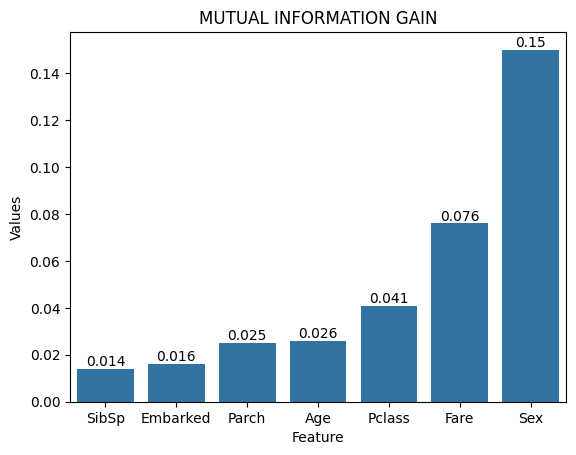

In [45]:
value3=mutual_info_classif(features,target)
mutual_info=pd.Series(value3)
mutual_info.index=features.columns
df3=pd.DataFrame({"Feature":mutual_info.index,"Values":mutual_info})
df3.sort_values(ascending=True,by="Values",inplace=True)
df3["Values"]=df3["Values"].round(3)
bar12=sns.barplot(x="Feature",y="Values",data=df3)
bar12.bar_label(bar12.containers[0])
plt.title("MUTUAL INFORMATION GAIN")
plt.show()

'CHI SQUARE TEST' AND 'MUTUAL INFORMATION' CLEARLY DEPICT THE MOST IMPORTANT COLUMNS i.e. 'Sex','Fare','Pclass','Age','Embarked'.

In [46]:
features.drop(["SibSp","Parch"],axis=1,inplace=True)

In [47]:
features.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,1,22,7,0
1,1,0,38,71,1
2,3,0,26,7,0
3,1,0,35,53,0
4,3,1,35,8,0


# SPLITTING THE DATA INTO TRAINING AND TESTING DATA

In [48]:
x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.3,random_state=24)

In [49]:
x_train.shape

(623, 5)

In [50]:
x_test.shape

(268, 5)

# MODEL TRAINING

### RANDOM FOREST CLASSIFIER

In [54]:
parameters={"criterion":['gini','entropy'],

            "max_depth":[2,6,10,14,18],
            "min_samples_split":[3,7,11,15,19],
            "max_features":["sqrt","log2"],
            "n_estimators":[100,200,300,400]}
model2=RandomForestClassifier()
tuning=GridSearchCV(model2,param_grid=parameters,cv=5,scoring='accuracy')
tuning.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 6, 10, 14, 18],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [3, 7, 11, 15, 19],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [55]:
tuning.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_split': 3,
 'n_estimators': 300}

In [56]:
train_pred2=tuning.predict(x_train)
test_pred2=tuning.predict(x_test)

# PERFORMANCE EVALUATION

#### ACCURACY

In [57]:
train_accuracy2=accuracy_score(train_pred2,y_train)
print("Training Accuracy- ",train_accuracy2.round(2))

Training Accuracy-  0.94


In [58]:
test_accuracy2=accuracy_score(test_pred2,y_test)
print("Test Accuracy- ",test_accuracy2.round(2))

Test Accuracy-  0.84


#### CLASSIFICATION REPORT

In [60]:
report=classification_report(test_pred2,y_test)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       181
           1       0.74      0.80      0.77        87

    accuracy                           0.84       268
   macro avg       0.82      0.83      0.83       268
weighted avg       0.85      0.84      0.84       268



#### CONFIDENCE MATRIX

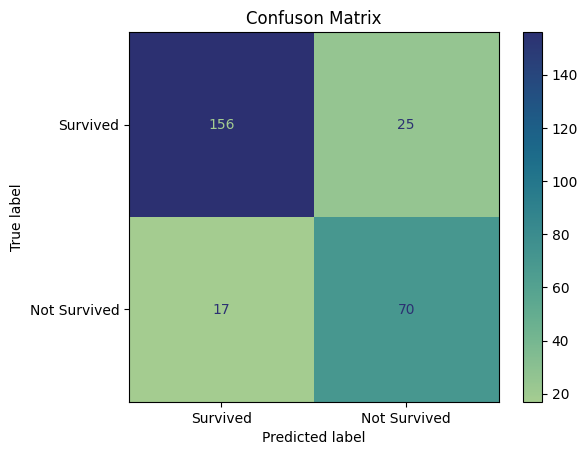

In [61]:
matrix2=confusion_matrix(test_pred2,y_test)
cm2=ConfusionMatrixDisplay(matrix2,display_labels=["Survived","Not Survived"])
cm2.plot(cmap="crest")
plt.title("Confuson Matrix")
plt.show()

# TESTING PREDICTIONS

In [62]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
pclass=3
sex=0
age=30
fare=9
embarked=0
new_data=[[pclass,sex,age,fare,embarked]]
pred=tuning.predict(new_data)
if(pred[0]==0):
    print("Not Survived")
else:
    print("Survived")

Not Survived
